# LSTM 이용한 텍스트 생성
- 데이터 다운로드:캐글 new york times comments
- Articles april2018

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning_2022_05/04.RNN/ArticlesApril2018.csv',encoding='latin1')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleadersâ Settlement Offer...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"âI understand that they could meet with us, ...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,Whatâs it like to eat at the second incarnat...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Torontoâs ...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [ ]:
headline=df.headline.values.tolist()

In [ ]:
headline[:5]

['Former N.F.L. Cheerleadersâ\x80\x99 Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [ ]:
len(headline)

1324

In [ ]:
#노이즈 데이터(unknown)제거
headlines=[line for line in df.headline.values if line !='Unknown']
len(headlines)

1214

In [ ]:
#encoding, 구둣점 제거, 소문자로 변환
import re

def preprocessing(s):
    s=s.encode('utf8').decode('ascii','ignore')
    s=re.sub('[^A-Za-z0-9 ]','',s)
    return s.lower()



In [ ]:
headlines=[preprocessing(line) for line in headlines]
headlines[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

- Keras 텍스트 전처리

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
# 단어 집합 생성
t=Tokenizer()
t.fit_on_texts(headlines)

In [ ]:
vocab_size=len(t.word_index)+1
vocab_size

3494

In [ ]:
#시퀀스 생성
sequences=[]
for line in headlines:
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequences.append(encoded[:i+1])
sequences

In [ ]:
max_len=max(len(seq) for seq in sequences)
max_len

24

In [ ]:
sequences=pad_sequences(sequences,maxlen=max_len, padding='pre')
sequences[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          99,  269],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   99,
         269,  371],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   99,  269,
         371, 1115],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   99,  269,  371,
        1115,  582],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   99,  269,  371, 1115,
         582,   52]], dtype=int32)

In [ ]:
X=sequences[:,:-1]
y=sequences[:,-1]
Y=to_categorical(y)
X.shape,Y.shape


((7803, 23), (7803, 3494))

### 모델 정의/설정/학습
- 임베딩 백터 갯수:10
- lstm 유닛 갯수:128


In [ ]:
import tensorflow as tf
import numpy as np
seed=2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
model=Sequential ([
                   Embedding(vocab_size,10,input_length=max_len-1),
                   LSTM(128), #activation='tanh'는 디폴트.
                   Dense(vocab_size,activation='softmax')
                   ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 10)            34940     
                                                                 
 lstm (LSTM)                 (None, 128)               71168     
                                                                 
 dense (Dense)               (None, 3494)              450726    
                                                                 
Total params: 556,834
Trainable params: 556,834
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])

In [ ]:
%time hist=model.fit(X,Y,epochs=200,verbose=1)

In [ ]:
hist.history['accuracy'][-1]

0.9169549942016602

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/DeepLearning_2022_05/04.RNN

/content/drive/MyDrive/Colab Notebooks/DeepLearning_2022_05/04.RNN


In [ ]:
from my_util import sentence_generation
print(sentence_generation(model,t,max_len,'former',8))
print(sentence_generation(model,t,max_len,'epa',8))
print(sentence_generation(model,t,max_len,'how',8))

former cheney aide is pardoned by trump in cia
epa to unveil a new rule its effect less
how to make facebook more accountable shame for the


훈련과정 시각화

In [ ]:
y_acc=hist.history['accuracy']
y_loss=hist.history['loss']
xs=np.arange(1,len(y_acc)+1)

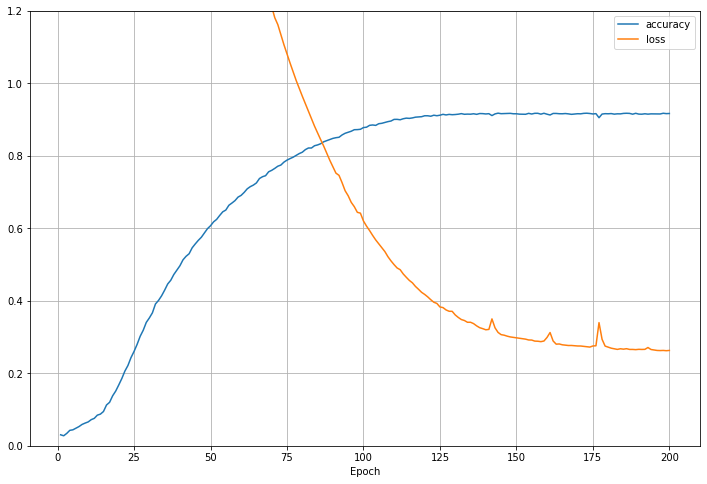

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs,y_acc,label='accuracy')
plt.plot(xs,y_loss,label='loss')
plt.legend(),plt.grid()
plt.ylim(0,1.2),plt.xlabel('Epoch')
plt.show()

### simpleRNN으로 하면?

In [ ]:
from tensorflow.keras.layers import SimpleRNN,GRU

In [ ]:
model2=Sequential ([
                   Embedding(vocab_size,10,input_length=max_len-1),
                   SimpleRNN(128), #activation='tanh'는 디폴트.
                   Dense(vocab_size,activation='softmax')
                   ])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 10)            34940     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               17792     
                                                                 
 dense_1 (Dense)             (None, 3494)              450726    
                                                                 
Total params: 503,458
Trainable params: 503,458
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile('adam','categorical_crossentropy',metrics=['accuracy'])

In [ ]:
%time hist2=model2.fit(X,Y,epochs=200,verbose=1)

Epoch 1/200
244/244 [==============================] - 6s 19ms/step - loss: 7.6586 - accuracy: 0.0293
Epoch 2/200
244/244 [==============================] - 5s 19ms/step - loss: 7.1148 - accuracy: 0.0320
Epoch 3/200
244/244 [==============================] - 4s 18ms/step - loss: 6.9043 - accuracy: 0.0434
Epoch 4/200
244/244 [==============================] - 5s 20ms/step - loss: 6.6197 - accuracy: 0.0549
Epoch 5/200
244/244 [==============================] - 5s 21ms/step - loss: 6.2928 - accuracy: 0.0577
Epoch 6/200
244/244 [==============================] - 5s 21ms/step - loss: 5.9598 - accuracy: 0.0643
Epoch 7/200
244/244 [==============================] - 6s 23ms/step - loss: 5.6420 - accuracy: 0.0689
Epoch 8/200
244/244 [==============================] - 4s 18ms/step - loss: 5.3280 - accuracy: 0.0824
Epoch 9/200
244/244 [==============================] - 4s 18ms/step - loss: 5.0305 - accuracy: 0.1011
Epoch 10/200
244/244 [==============================] - 4s 18ms/step - loss: 4.751

In [ ]:
hist2.history['accuracy'][-1]

0.9138792753219604

In [ ]:
from my_util import sentence_generation
print(sentence_generation(model,t,max_len,'former',8))
print(sentence_generation(model,t,max_len,'epa',8))
print(sentence_generation(model,t,max_len,'how',8))

former cheney aide is pardoned by trump in cia
epa to unveil a new rule its effect less
how to make facebook more accountable shame for the


훈련과정 시각화

In [ ]:
y_acc2=hist2.history['accuracy']
y_loss2=hist2.history['loss']
xs2=np.arange(1,len(y_acc2)+1)

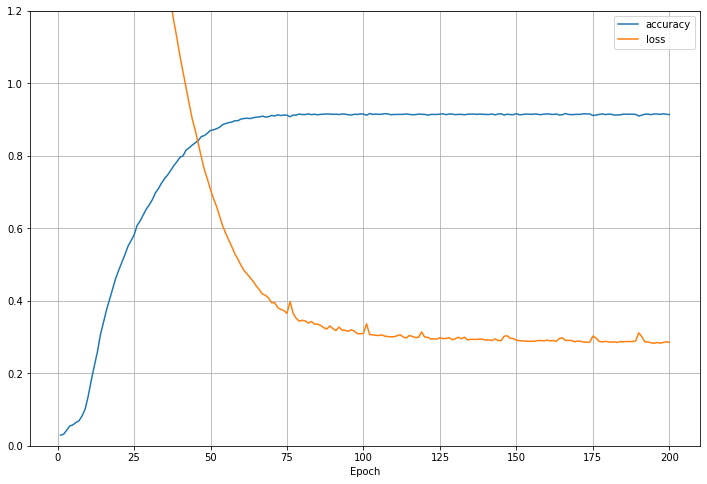

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs2,y_acc2,label='accuracy')
plt.plot(xs2,y_loss2,label='loss')
plt.legend(),plt.grid()
plt.ylim(0,1.2),plt.xlabel('Epoch')
plt.show()